Analyzing Media Coverage Of Other Countries in Austria
===


The aim of this project is to find out how reporting in Austria's print media about certain countries has changed over time (sentiment, which topics). In two further steps, I would also like to go down to the level of the individual newspapers and their authors and take an explorative look at whether there are tendencies/bias here. As countries of interest I choose Balkan countries because of their proximity to Austria and their long history of conflict.

    Text corpora: Austrian newspaper articles (or their respective twitter posts)
    Language: German
    Time: 2000–2022
    Method: Adding country labels to the articles, Sentiment Scores (, extracting underlying topics of the articles, e.g. with fuzzy topic modeling) 
    
According to https://de.wikipedia.org/wiki/Liste_%C3%B6sterreichischer_Zeitungen_und_Zeitschriften derstandard.at and krone.at reach the most people online, they also cover Austrian society quite well. So, initially, I will focus on these two and might add some more newspapers at a later stage.

* Focus on 2 countries: Serbia and Croatia (like Austria now a EU country)
* I will label an article with "Serbia" if the ratio of amount of words that relate to "Serbia"  compared to words that relate to "Croatia" is greater than 4
* I will also try to find out if there are certain authors who are responsible for a certain tendency.
* Another analysis could be build upon the ratio of "Serbia" and "Albania" or "Kosovo"

**Hypothesis 1: Tweets about Croatia are on average more positive than tweets about Serbia**

Inspiration:
https://www.brookings.edu/blog/africa-in-focus/2017/08/08/exploring-media-sentiment-around-africa-country-analysis/

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
import os
import json
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from bs4 import BeautifulSoup
import requests


data_dir = "data/twitter"

if os.path.exists(data_dir) == False:
    os.makedirs(data_dir)


def dl_user(user, max_results=None, local=False):
    """
    Function to download tweets by username.
    Set local to True, if tweets have already
    been downloaded and are available in data_dir.

    Returns a DataFrame.

    """

    if local == False:
        with open(data_dir + f"/user-{user}.json", "w+") as fo:
            if max_results == None:
                cmd_list = ["snscrape", "--jsonl", "twitter-user", user]
            else:
                cmd_list = [
                    "snscrape",
                    "--jsonl",
                    "-n " + str(max_results),
                    "twitter-user",
                    user,
                ]
            p = subprocess.Popen(cmd_list, stdout=fo)
            p.wait()

    with open(data_dir + f"/user-{user}.json", "r") as fo:
        tweets = fo.readlines()

    tweets = [json.loads(tweets[i]) for i in range(0, len(tweets))]
    print("loaded", len(tweets), "tweets\n")

    df_tweets = pd.DataFrame(tweets)
    df_tweets["date"] = pd.to_datetime(df_tweets["date"])

    return df_tweets[["date", "rawContent"]]

# 1. Scraping newspaper articles

## 1.1. derStandard.at


In [3]:
df_tweets = dl_user("derstandardat", max_results=None, local=True)

df_tweets.head()

loaded 272281 tweets



,date,rawContent
0,2023-01-25 09:50:19+00:00,Massive Ausfälle bei Microsoft Teams und Outlo...
1,2023-01-25 09:50:18+00:00,"ÖSV-Techniktrainer Kroisleitner: ""Potenzial de..."
2,2023-01-25 09:50:17+00:00,"Leopard-Lieferung: Selenskyj will mehr als ""ze..."
3,2023-01-25 09:33:54+00:00,"""IBES"" 2023: Jana ist raus – Werden Sie sie ve..."
4,2023-01-25 09:04:32+00:00,Chanels Haute Couture: Show führte in den Zirk...


### Extract urls for complete articles

<div class="alert alert-warning">Takes ages! Speed this up!!!</div>

In [4]:
def get_url(txt):
    """
    Get url from tweet.

    """

    try:
        return re.search("(?P<url>https?://[^\s]+)", txt).captures()[0]
    except:
        return ""


from time import sleep


def get_direct_url(url):
    """
    Direct url

    """

    url_direct = None

    if url != "":
        while url_direct == None:
            print(".", end="")
            try:
                page = requests.get(
                    url, headers={"User-Agent": "Mozilla/5.0"}, timeout=(0.5, 27)
                )
                html = BeautifulSoup(page.text, "html.parser")
                url_direct = html.find("link")
                if url_direct == None:
                    url_direct = ""
                else:
                    url_direct = url_direct.get("href")
            except Exception as e:
                ...
        print("1", end="")

        sleep(0.5)

        return url_direct

    else:
        print("0", end="")
        return url

First tep: Get short url from text

In [11]:
%%time


df_tweets["url"] = df_tweets["rawContent"].apply(lambda x: get_url(x))

CPU times: user 2.8 s, sys: 9.62 ms, total: 2.81 s
Wall time: 2.81 s


### Preprocess text

<div class="alert alert-warning">Necessary?</div>

In [19]:
#
#
#

### Save to file

In [14]:
df_tweets.to_csv(data_dir + "/media_coverage_with_url.csv", index=False)

### Load from file

In [5]:
df_tweets = pd.read_csv(data_dir + "/media_coverage_with_url.csv")
df_tweets.tail()

,date,rawContent,url
272432,2009-05-13 13:14:27+00:00,"Mölzer im Chat: ""Kulturkampf zwischen Christen...",http://derStandard.at/EU
272433,2009-05-12 14:24:59+00:00,Morgen geht es weiter mit den EU-Chats. Andrea...,http://derStandard.at/EU
272434,2009-05-12 14:23:09+00:00,"""Wenn wir die EU nicht hätten, müssten wir sie...",NaN
272435,2009-03-26 16:16:10+00:00,"Neu: Permalinks für Postings, Artikel und Schw...",http://tinyurl.com/deqklo
272436,2009-03-26 15:49:04+00:00,First tweet!,NaN



### Compute sentiment scores for all tweets

#### Textblob

In [67]:
from textblob_de import TextBlobDE as TextBlob


df_tweets["sentiment_textblob"] = df_tweets.rawContent.apply(
    lambda x: TextBlob(x).polarity
)

Save

In [73]:
df_tweets.to_csv(data_dir + "/media_coverage_with_sentiment.csv", index=False)

Load

In [74]:
df_tweets = pd.read_csv(
    data_dir + "/media_coverage_with_sentiment.csv",
    parse_dates=["date"],
)
df_tweets.head()

,date,rawContent,url,sentiment_textblob
0,2023-01-25 09:50:19+00:00,Massive Ausfälle bei Microsoft Teams und Outlo...,https://t.co/8vICahGNxr,-1.0
1,2023-01-25 09:50:18+00:00,"ÖSV-Techniktrainer Kroisleitner: ""Potenzial de...",https://t.co/84r4nazixi,0.0
2,2023-01-25 09:50:17+00:00,"Leopard-Lieferung: Selenskyj will mehr als ""ze...",https://t.co/YnMS20JJ6X,0.0
3,2023-01-25 09:33:54+00:00,"""IBES"" 2023: Jana ist raus – Werden Sie sie ve...",https://t.co/RKk4pRXw1Y,0.0
4,2023-01-25 09:04:32+00:00,Chanels Haute Couture: Show führte in den Zirk...,https://t.co/mg2CIOEm7c,0.0


#### germansentiment

In [169]:
from germansentiment import SentimentModel

gsm = SentimentModel()


def german_sentiment(txt):
    """

    returns sentiment score for
    German language.

    """

    classes, [probs] = gsm.predict_sentiment([txt], output_probabilities=True)
    probs = dict(probs)

    return probs["positive"] - probs["negative"]

In [182]:
%%time

df_tweets["sentiment_gs"] = df_tweets.rawContent.apply(lambda x: german_sentiment(x))

CPU times: user 13h 18min 26s, sys: 6min 35s, total: 13h 25min 2s
Wall time: 3h 22min 38s


In [193]:
# Quick check of correlation between the 2 kind of sentiment scores

df_tweets[["sentiment_textblob", "sentiment_gs"]].corr()

,sentiment_textblob,sentiment_gs
sentiment_textblob,1.000000,0.111037
sentiment_gs,0.111037,1.000000


Save

In [183]:
df_tweets.to_csv(data_dir + "/media_coverage_with_sentiment2.csv", index=False)

Load

In [184]:
df_tweets = pd.read_csv(
    data_dir + "/media_coverage_with_sentiment2.csv",
    parse_dates=["date"],
)
df_tweets.head()

,date,rawContent,url,sentiment_textblob,sentiment_gs
0,2023-01-25 09:50:19+00:00,Massive Ausfälle bei Microsoft Teams und Outlo...,https://t.co/8vICahGNxr,-1.0,-0.995497
1,2023-01-25 09:50:18+00:00,"ÖSV-Techniktrainer Kroisleitner: ""Potenzial de...",https://t.co/84r4nazixi,0.0,-0.002756
2,2023-01-25 09:50:17+00:00,"Leopard-Lieferung: Selenskyj will mehr als ""ze...",https://t.co/YnMS20JJ6X,0.0,-0.000083
3,2023-01-25 09:33:54+00:00,"""IBES"" 2023: Jana ist raus – Werden Sie sie ve...",https://t.co/RKk4pRXw1Y,0.0,-0.001618
4,2023-01-25 09:04:32+00:00,Chanels Haute Couture: Show führte in den Zirk...,https://t.co/mg2CIOEm7c,0.0,-0.000021


#### Flair (currently only classifies into OTHER and OFFENSIVE)

### Which countries are the tweets referring to (Serbia, Croatia)?

In [5]:
countries = dict(
    serbia=["serbien", "serbe", "serbin", "serbisch", "serbo"],
    croatia=["kroatien", "kroate", "kroatin", "kroatisch", "kroato"],
    romania=["rumänien", "rumäne", "rumänin", "rumänisch"],
    hungary=["ungarn", "ungar", "ungarin", "ungarisch", "ungaro"],
    finland=["finnland", "finne", "finnin", "finnisch", "finno"],
    norway=["norwegen", "norweger", "norwegisch"],
    sweden=["schweden", "schwedin", "schwedisch"],
    danmark=["dänisch", "dänen", "dänin", "dänisch"],
    poland=["polen", "pole", "polin", "polnisch"],
    bulgaria=["bulgarien", "bulgare", "bulgarin", "bulgarisch"],
    russia=["russland", "russe", "russin", "russen", "russisch"],
    ukraine=["ukraine", "ukrainisch"],
    germany=["deutschland", "deutsche"],
    frankreich=["frankreich", "franzose", "französi"],
    slovenia=["slowenien", "slowene", "sloweni"],
    italy=["italien"],
    spain=["spanien", "spanier", "spanisch"],
    portugal=["portual", "portugiese", "portugiesin", "portugiesisch"],
    switzerland=["schweiz"],
    austria=["österreich"],
    slovakia=["slowakei", "slowake", "slowakin", "slowakisch"],
    czechia=["tschechien", "tscheche", "tschechin", "tschechisch"],
    belarus=[
        "belarus",
        "weißrussland",
        "weissrussland",
        "weißrussisch",
        "weissrussisch",
        "weißrusse",
        "weissrusse",
        "weißrussin",
        "weissrussin",
    ],
    bosnia=["bosnien", "bosnisch", "herzegowina", "bosnier", "herzegowinisch"],
    montenegro=["montenegro", "montenegriner", "montenegrinisch"],
    albania=["albanien", "albaner", "albanisch"],
)

#### Function for finding tweets about countries

In [6]:
def get_country(df_tweets, country, not_country=None, and_country=None):
    """

    Filters DataFrame with tweets to country-
    specific tweets.

    Optional: Can exclude tweeds of specific other countries
    via not_country variable.

    """
    df_country = df_tweets[
        ["date", "rawContent", "url", "sentiment_gs", "sentiment_textblob"]
    ].copy()

    if not_country != None:

        df_country = df_country.loc[
            df_country.rawContent.str.lower().str.contains(
                "|".join(country), regex=True
            )
            & ~df_country.rawContent.str.lower().str.contains(
                "|".join(not_country), regex=True
            )
        ].reset_index(drop=True)

    else:
        df_country = df_country.loc[
            df_country.rawContent.str.lower().str.contains(
                "|".join(country), regex=True
            )
        ].reset_index(drop=True)

    return df_country

### Compare sentiments betweens countries

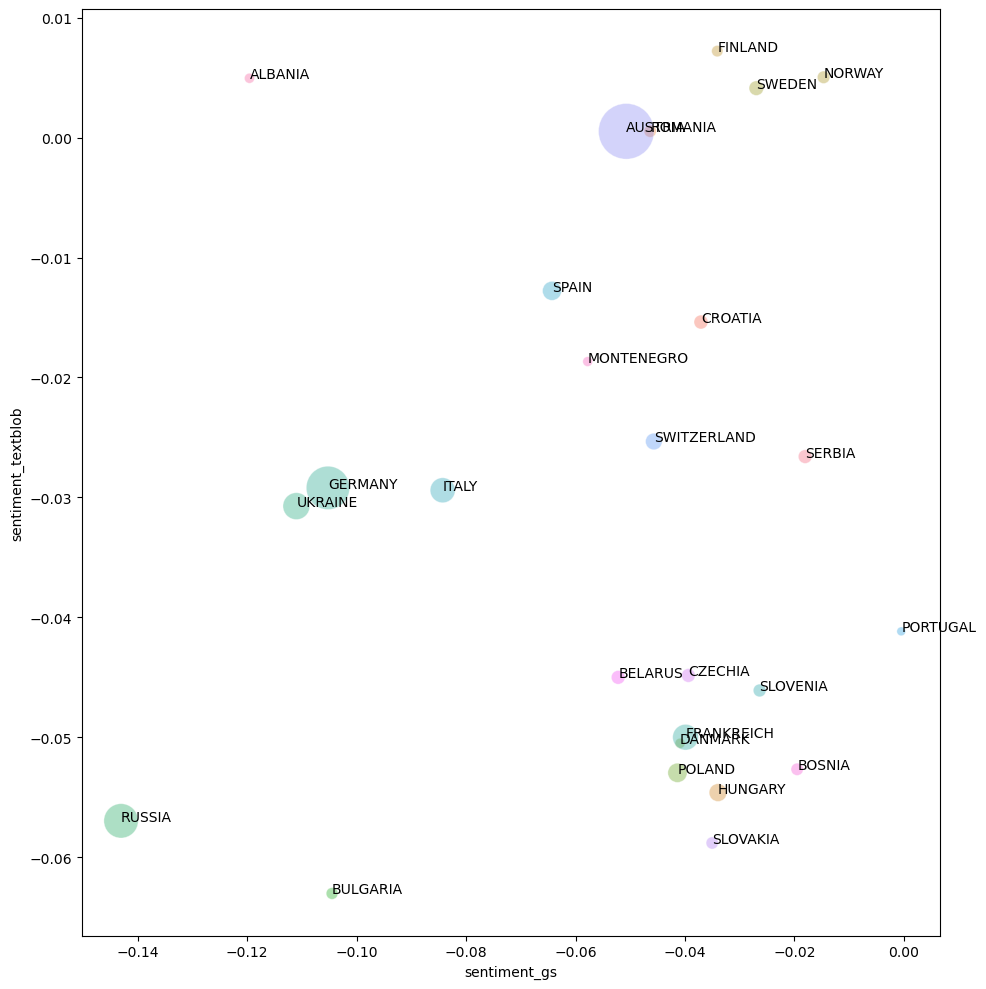

In [189]:
df_scores = pd.DataFrame()

for key in countries.keys():
    df_scores_tmp = get_country(df_tweets, countries[key])[
        ["sentiment_gs", "sentiment_textblob"]
    ]
    count = len(df_scores_tmp)
    df_scores_tmp = pd.DataFrame(
        df_scores_tmp.mean(),
        columns=[key],
    ).T
    df_scores_tmp["count"] = count
    df_scores = pd.concat([df_scores, df_scores_tmp], sort=False)

df_scores = df_scores.reset_index().rename(columns={"index": "country"})

plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df_scores,
    x="sentiment_gs",
    y="sentiment_textblob",
    hue="country",
    size="count",
    sizes=(40, 1600),
    legend=False,
    alpha=0.4,
)

for tup in df_scores.itertuples():
    plt.annotate(tup[1].upper(), (tup[2], tup[3]))

plt.tight_layout()

In [195]:
# check correlation of sentiment scores fr these countries
df_scores[["sentiment_textblob", "sentiment_gs"]].corr()

,sentiment_textblob,sentiment_gs
sentiment_textblob,1.000000,0.065768
sentiment_gs,0.065768,1.000000


#### Find tweets about Serbia (but not Croatia)

In [ ]:
%%time

df_serbien = get_country(df_tweets, countries["serbia"], countries["croatia"])
df_serbien["direct_url"] = df_serbien["url"].apply(lambda x: get_direct_url(x))

df_serbien.head()

#### Find tweets about Croatia (but not Serbia)

In [ ]:
%%time

df_kroatien = get_country(df_tweets, countries["croatia"], countries["serbia"])
df_kroatien["direct_url"] = df_kroatien["url"].apply(lambda x: get_direct_url(x))

df_kroatien.head()

#### Find tweets about both Serbia and Croatia

In [ ]:
%%time

df_both = df_tweets[
    ["date", "rawContent", "sentiment_gs", "sentiment_textblob", "url"]
].copy()

df_both = df_both.loc[
    df_both.rawContent.str.lower().str.contains(
        "|".join(countries["croatia"]), regex=True
    )
    & df_both.rawContent.str.lower().str.contains(
        "|".join(countries["serbia"]), regex=True
    )
].reset_index(drop=True)
df_both["direct_url"] = df_both["url"].apply(lambda x: get_direct_url(x))

print(len(df_both), "tweets")

df_both.head()

Save

In [220]:
df_both.to_csv(data_dir + "/df_both.csv", index=False)
df_serbien.to_csv(data_dir + "/df_serbien.csv", index=False)
df_kroatien.to_csv(data_dir + "/df_kroatien.csv", index=False)

Load

In [221]:
df_both = pd.read_csv(data_dir + "/df_both.csv")
df_serbien = pd.read_csv(data_dir + "/df_serbien.csv")
df_kroatien = pd.read_csv(data_dir + "/df_kroatien.csv")

#### Controls: Find tweets about other countries (Romania, Hungary, Finland)

In [ ]:
df_rumanien = get_country(df_tweets, countries["romania"])


df_rumanien.head()

In [ ]:
df_ungarn = get_country(df_tweets, countries["hungary"])


df_ungarn.head()

In [ ]:
df_finnland = get_country(df_tweets, countries["finland"])


df_finnland.head()

In [ ]:
from scipy.stats import ttest_ind
from pingouin import ttest

*t*-Test

In [ ]:
ttest(
    df_kroatien.sentiment_textblob, df_serbien.sentiment_textblob, alternative="greater"
)

Permutation test

In [ ]:
ttest_ind(
    df_kroatien.sentiment_textblob,
    df_serbien.sentiment_textblob,
    permutations=100_000,
    alternative="greater",
)

<div class="alert alert-info">More positive coverage of Croatia over Serbia is significant, but the difference is small.</div>

*t*-Tests vs baseline

In [ ]:
df_tweets["sentiment_textblob"] = df_tweets.rawContent.apply(
    lambda x: TextBlob(x).polarity
)

df_tweets.sentiment_textblob.mean()

In [ ]:
ttest_ind(df_kroatien.sentiment_textblob, df_tweets.sentiment_textblob)

In [ ]:
ttest_ind(df_serbien.sentiment_textblob, df_tweets.sentiment_textblob)

### Scrape the complete articles

In [ ]:
from bs4 import BeautifulSoup


def get_text(url):
    try:
        soup = BeautifulSoup(requests.get(url).content, "html.parser")
        txt = soup.find_all("div", class_="article-text")[0].text
    except:
        txt = ""
    return txt


df_both["article_text"] = df_both["direct_url"].apply(lambda x: get_text(x))
df_serbien["article_text"] = df_serbien["direct_url"].apply(lambda x: get_text(x))
df_kroatien["article_text"] = df_kroatien["direct_url"].apply(lambda x: get_text(x))

Save

In [223]:
df_both.to_csv(data_dir + "/df_both_with_article_short.csv", index=False)
df_serbien.to_csv(data_dir + "/df_serbien_with_article_short.csv", index=False)
df_kroatien.to_csv(data_dir + "/df_kroatien_with_article_short.csv", index=False)

Load

In [7]:
df_both = pd.read_csv(data_dir + "/df_both_with_article_short.csv")
df_serbien = pd.read_csv(data_dir + "/df_serbien_with_article_short.csv")
df_kroatien = pd.read_csv(data_dir + "/df_kroatien_with_article_short.csv")

Some preprocessing. Maybe this has to be fixed. Evaluate only sentence by sentence and make this column a list of sentence? Adapt the functions fo building the sentiment scores then.

In [227]:
df_serbien["article_text"] = df_serbien.article_text.fillna("")
df_kroatien["article_text"] = df_kroatien.article_text.fillna("")
df_both["article_text"] = df_both.article_text.fillna("")

df_serbien["article_text"] = df_serbien.article_text.str.replace("\n", "")
df_kroatien["article_text"] = df_kroatien.article_text.str.replace("\n", "")
df_both["article_text"] = df_both.article_text.str.replace("\n", "")

### Compute the sentiment scores for articles (articles incomplete here)

Build means

Compute means by year and plot

## A new attempt to newspaper scraping

Selenium

In [8]:
url = df_serbien.direct_url[3]

In [9]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

driver = webdriver.Firefox()

driver.get(url)

iframes = driver.find_elements(By.TAG_NAME, "iframe")

# wait for both iframes to appear
while len(iframes) < 2:
    iframes = driver.find_elements(By.TAG_NAME, "iframe")

iframe = iframes[1]


WebDriverWait(driver, 20).until(EC.frame_to_be_available_and_switch_to_it(iframe))
WebDriverWait(driver, 20).until(
    EC.element_to_be_clickable((By.CSS_SELECTOR, ".primary"))
).click()

# switch to new window
new_window = driver.window_handles
driver.switch_to.window(new_window[0])

from time import sleep

sleep(2)

article_title = driver.find_element(By.CLASS_NAME, "article-title")
article_subtitle = driver.find_element(By.CLASS_NAME, "article-subtitle")
article_body = driver.find_element(By.CLASS_NAME, "article-body")

print(article_title.text)

print(article_subtitle.text)

for p in article_body.find_elements(By.TAG_NAME, "p"):
    print(p.text)

driver.quit()

Konflikt zwischen Kosovo und Serbien: Schlecht für den Rechtsstaat
Durch die Art der Konfliktlösung der EU wurde das wichtigste Gut westlicher Demokratien, die Rechtsstaatlichkeit, verhandelbar
Der Abbau der Barrikaden im Norden des Kosovo bringt keinen nachhaltigen Weihnachtsfrieden. Besonders verstörend ist, dass die EU und die Nato auf Bedingungen von militanten Aktivisten, die unter der Kontrolle des serbischen Präsidenten Aleksandar Vučić stehen und kein Verhandlungsmandat haben, eingingen.
Durch diese Art der Konfliktlösung der EU wurde nämlich das wichtigste Gut westlicher Demokratien, die Rechtsstaatlichkeit, verhandelbar. Die Bilanz der inszenierten Serbien-Kosovo-Krise ist verheerend: Der Kosovo darf nicht dafür sorgen, dass alle Kfz-Besitzer die vorgesehenen Nummerntafeln verwenden, und er kann nicht zeitgerecht Wahlen abhalten. Leute, die illegalerweise den Verkehr zum Stillstand bringen, können nicht dafür belangt werden, und die eigene Polizei darf ihr Gewaltmonopol nicht

### Function

In [10]:
from time import sleep


def get_derstandard_article(url):
    """

    Scrapes article from derstandard.at
    and return title, subtitle and
    complete article text

    """

    driver = webdriver.Firefox()

    driver.set_script_timeout(30)
    try:
        driver.get(url)

    except:
        print("Could not process url:", url)
        return "", "", ""

    # switch to iframe (when it is avilable) with button and click it
    iframes = driver.find_elements(By.TAG_NAME, "iframe")

    # wait for both iframes to appear
    while len(iframes) < 2:
        iframes = driver.find_elements(By.TAG_NAME, "iframe")

    iframe = iframes[1]
    WebDriverWait(driver, 20).until(EC.frame_to_be_available_and_switch_to_it(iframe))
    WebDriverWait(driver, 20).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, ".primary"))
    ).click()

    # switch to new window
    new_window = driver.window_handles
    driver.switch_to.window(new_window[0])

    sleep(2)

    try:
        article_title = driver.find_element(By.CLASS_NAME, "article-title").text
        article_subtitle = driver.find_element(By.CLASS_NAME, "article-subtitle").text
        article_body = driver.find_element(By.CLASS_NAME, "article-body")
        article_text = [p.text for p in article_body.find_elements(By.TAG_NAME, "p")]
        article_text = "\n".join(article_text)

    except:
        article_title = ""
        article_subtitle = ""
        article_text = ""

    driver.quit()

    return article_title, article_subtitle, article_text

Run Function on one url

In [11]:
url = df_serbien.direct_url[2]
a_title, a_subtitle, a_text = get_derstandard_article(url)

a_text

'Eine KFOR-Streife überwacht im Dezember eine Straßenblockade im Kosovo.\nPristina – Im Kosovo hat ein Soldat außerhalb seiner Dienstzeit zwei ethnische Serben mit Schüssen verwundet und damit Sorgen vor einem Wiederaufflammen der ethnischen Konflikte ausgelöst. Der 33 Jahre alte Soldat der Kosovo-Sicherheitskräfte sei festgenommen worden. Die beiden Opfer – ein 21-jähriger Mann und ein 11-jähriger Junge – wurden im Krankenhaus operiert und sind außer Lebensgefahr.\nDer Soldat hatte im Ski-Ort Shterpce im Südkosovo das Feuer auf den 11-jährigen und den 21-jährigen Serben eröffnet. Im Gebiet um Strpce leben mehrheitlich Serben. Einige Serben blockierten nach dem Vorfall die Hauptverbindungsstraße von Shterpce zum Rest des Landes. Nach Angaben der serbischen Regierung trugen die beiden Cousins einen Eichenstamm, der traditionell von serbisch-orthodoxen Christen zum orthodoxen Weihnachtsfest am 7. Jänner geschlagen wird.\nDie kosovarische Präsidentin Vjosa Osmani und Ministerpräsident Alb

Run function on dataframe

Do it iteratively

In [ ]:
for i, row in df_serbien.iterrows():
    df_serbien.loc[i, ["article_title", "article_subtitle", "article_text"]] = get_derstandard_article(row.direct_url)